#  Create autoencoder for dimensionality reduction of weather map

- It may be better to train the embedding by performing a regression task, e.g. train a model to predict the storm intensities, widths and locations. If the embedding is very late in this network (such as the final hidden layer), it would force the embedding to represent something semantically meaningful (i.e. which reveals the structure in the data) so that it may be easily mapped onto the final result. The main problem here is that we have an output with variable size (the number of storms may vary from 0 to 5, each of which has four co-ordinates in this problem spec). Firstly, it may require a relatively large embedding to capture this semantic structure in a way which can be easily mapped onto a 20+ dimensional output space. This runs counter to our motivation of dimensionality reduction. Secondly, it is hard to frame this regression task without a lot of technical tricks to deal with the variable output size. I prefer to keep it simple and train an effective autoencoder, which is not too difficult, with as-small an embedding length as can be achieved whilst still being able to reconstruct the storms. We simply note that the embedding space may lack structure (the model instead deciding to capture this in the series of dense and deconv layers which follow the embedding), and this may impact the learning of the RL model, which then has to do more work to infer the embedded weather correctly.
- To keep the embedding as semantically meaningful as possible, we want to use the minimum number of dense layers in the decoder (whilst still enabling good reconstruction ability, so that we do not need to make the mbedding layer any bigger than necessary).
- N.B. by passing through a bottleneck we actually create a 'denoising autoencoder'. This is because the bottleneck does not preserve information on individual pixel fluctuations, partly because we discard this information when performing convolutions with a small number of kernels, partly because we discard info when maxpooling, and partly because we don't have the capacity to reconstruct individual pixels without having many more deconv kernels (therefore this is no motivation (== gradient) towards retaining this information). This, along with the limited complexity of the image reconstruction, leads to the output being much smoother than the input. Since the optimal MSE is achieved by averaging out the noise fluctuations in this setting, we effectively train the model to 'denoise' the image.

In [1]:
###
###  Import packages
###

import math, os, pickle, sys, time

import numpy as np

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers     import BatchNormalization, Conv2D, Conv2DTranspose, Concatenate, Dense, Dropout, Flatten, Input, MaxPooling2D, Rescaling, Reshape
from tensorflow.keras.models     import Model
from tensorflow.keras.callbacks  import EarlyStopping
from tensorflow.keras.optimizers import Adam

print("TensorFlow has found devices:")
for device in tf.config.list_physical_devices() :
    print(f"-  {device}")

#  Set matplotlib interactive backend via linemagic
#  -  interative backend allows plots to be shown in notebook
#  -  keep an eye on memory leak caused by creation of GUI objects which are not deleted
#  -  choose non-interative backend such as 'agg' to avoid memory leak, but cannot plot in notebook

%matplotlib inline


/Users/Ste/miniforge3/envs/tf-sandbox-py3p9/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


TensorFlow has found devices:
-  PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
-  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
###
###  Utility functions
###

def generate_directory_for_file_path(fname, print_msg_on_dir_creation=True) :
    """
    Create the directory structure needed to place file fname. Call this before fig.savefig(fname, ...) to 
    make sure fname can be created without a FileNotFoundError
    Input:
       - fname: str
                name of file you want to create a tree of directories to enclose
                also create directory at this path if fname ends in '/'
       - print_msg_on_dir_creation: bool, default = True
                                    if True then print a message whenever a new directory is created
    """
    while "//" in fname :
        fname = fname.replace("//", "/")
    dir_tree = fname.split("/")
    dir_tree = ["/".join(dir_tree[:i]) for i in range(1,len(dir_tree))]
    dir_path = ""
    for dir_path in dir_tree :
        if len(dir_path) == 0 : continue
        if not os.path.exists(dir_path) :
            os.mkdir(dir_path)
            if print_msg_on_dir_creation :
                print(f"Directory {dir_path} created")
            continue
        if os.path.isdir(dir_path) : 
            continue
        raise RuntimeError(f"Cannot create directory {dir_path} because it already exists and is not a directory")
    


In [3]:
###
###  Method for weather map generation
###

def generate_map(square_size=40, storm_density=0.003, calm_weather_intensity=2., storm_intensity_low=8., 
                 storm_intensity_high=14., storm_decay_rate_low=.7, storm_decay_rate_high=1.4,
                 max_weather_intensity=18) :
    '''
    '''
    ##    Generate storm locations and intensities
    storm_pad       = math.floor(storm_intensity_high / storm_decay_rate_low / 2.)
    mean_num_storms = storm_density * square_size * square_size
    num_storms      = np.random.poisson(lam=mean_num_storms)
    storms_list     = []
    for storm_idx in range(num_storms) :
        storm_x, storm_y = np.random.uniform(low=-storm_pad, high=square_size+storm_pad-1, size=(2,))
        storm_i  = np.random.uniform(low=storm_intensity_low, high=storm_intensity_high)
        storm_dr = np.random.uniform(low=storm_decay_rate_low, high=storm_decay_rate_high)
        storms_list.append([storm_i, storm_dr, storm_x, storm_y])
    ##    Generate weather map
    weather_map = np.zeros(shape=(square_size, square_size, 1))
    for x in range(square_size) :
        for y in range(square_size) :
            weather_intensity = calm_weather_intensity
            for storm_i, storm_dr, storm_x, storm_y in storms_list :
                r = np.sqrt((x-storm_x)**2 + (y-storm_y)**2)
                weather_intensity += max(0, storm_i - storm_dr*r)
            weather_map[x, y, 0] = min(np.random.poisson(lam=weather_intensity), max_weather_intensity)
    ##    Return new storm and weather containers
    return weather_map


In [4]:
###
###  Method for weather map visualisation
###

def create_weather_plot(weather_map, show=False, close=False, savefile="") :
    '''
    '''
    fig = plt.figure(figsize=(6.5, 6))
    ax  = fig.add_axes([0   , 0., 6./6.5, 1.])
    cax = fig.add_axes([0.97, 0., .03   , 1.])
    ax .tick_params(axis="both", which="both", right=True, top=True, direction="in", labelsize=14)
    cax.tick_params(axis="both", which="both", right=True, top=True, direction="in", labelsize=14)
    im = ax.imshow(weather_map[:,:,0].transpose(), origin="lower", vmin=0, vmax=20)
    plt.colorbar(im, cax=cax, cmap="r_viridis")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax .set_title("Weather map", rotation=0, fontsize=20, pad=15)
    cax.set_title("Penalty"    , rotation=0, fontsize=20, pad=15)
    if len(savefile) > 0 :
        generate_directory_for_file_path(savefile)
        fig.savefig(savefile, bbox_inches="tight", dpi=dpi)
        print(f"Figure saved to file {savefile}")
    if show :
        plt.show()
    if close :
        plt.cla()
        plt.clf()
        plt.close(fig)
    return fig, ax, cax, im

In [5]:
###
###  Generate a dataset of weather maps for training + validation
###

square_size           = 40
max_weather_intensity = 18

num_data_X = int(1e5)

data_X_np = []
for data_idx in range(num_data_X) :
    sys.stdout.write(f"\rGenerating datapoint {1+data_idx} / {num_data_X}")
    data_X_np.append(generate_map(square_size=square_size, max_weather_intensity=max_weather_intensity))
data_X_np = np.array(data_X_np)


Generating datapoint 100000 / 100000

In [6]:
###
###  Convert data to Tensor format
###

data_X = tf.constant(data_X_np)

split_idx = int(0.3*len(data_X_np))
data_X_train = tf.constant(data_X_np[split_idx:])
data_X_val   = tf.constant(data_X_np[:split_idx])

print(f"Dataset of length {len(data_X_np)}")


Metal device set to: Apple M1 Pro
Dataset of length 100000


In [7]:
###
###   Method creates autoencoder model for dimensionality reduction of weather maps
###


def create_encoder_model(square_size, weather_max, embedding_length, learning_rate=1e-3, name="no_name", dropout=0.1, 
                         batchnorm=True, num_kernels=32, dense_width=300, num_encoder_dense_layers=1, 
                         num_decoder_dense_layers=1) :
    '''
    '''
    input_layer  = Input((square_size, square_size, 1))
    
    encoder_layer   = Rescaling(2./weather_max, offset=-0.5*weather_max, name="encoder_prescale")(input_layer)
    encoder_layer   = Conv2D(num_kernels, kernel_size=(2,2), activation="relu", padding="same", name="encoder_conv2D_1")(encoder_layer)
    if batchnorm :
        encoder_layer   = BatchNormalization(name="encoder_batchnorm_1")(encoder_layer)
    if dropout > 0 :
        encoder_layer = Dropout(dropout, name="encoder_dropout_1")(encoder_layer)
    encoder_layer   = MaxPooling2D((2, 2), padding="same", name="encoder_maxpool2D_1")(encoder_layer)
    encoder_layer   = Conv2D(num_kernels, kernel_size=(2,2), activation="relu", padding="same", name="encoder_conv2D_2")(encoder_layer)
    if batchnorm :
        encoder_layer   = BatchNormalization(name="encoder_batchnorm_2")(encoder_layer)
    if dropout > 0 :
        encoder_layer = Dropout(dropout, name="encoder_dropout_2")(encoder_layer)
    encoder_layer   = MaxPooling2D((2, 2), padding="same", name="encoder_maxpool2D_2")(encoder_layer)
    convolved_shape = encoder_layer.shape[1:]
    convolved_len   = np.product(convolved_shape)
    encoder_layer   = Flatten(name="encoder_flatten")(encoder_layer)
    for dense_idx in range(num_encoder_dense_layers) :
        encoder_layer = Dense(dense_width, activation="relu", name=f"encoder_dense_1_{dense_idx}")(encoder_layer)
        if batchnorm :
            encoder_layer = BatchNormalization(name=f"encoder_batchnorm_1_{dense_idx}")(encoder_layer)
        if dropout > 0 :
            encoder_layer = Dropout(dropout, name=f"encoder_dropout_1_{dense_idx}")(encoder_layer)
    encoder_layer = Dense(embedding_length, activation="linear", name="encoder_output")(encoder_layer)
    
    decoder_layer = encoder_layer
    for dense_idx in range(num_decoder_dense_layers) :
        decoder_layer = Dense(dense_width, activation="relu", name=f"decoder_dense_1_{dense_idx}")(decoder_layer)
        if batchnorm :
            decoder_layer = BatchNormalization(name=f"decoder_batchnorm_1_{dense_idx}")(decoder_layer)
        if dropout > 0 :
            decoder_layer = Dropout(dropout, name=f"decoder_dropout_1_{dense_idx}")(decoder_layer)
    decoder_layer = Dense(convolved_len, activation="relu", name="decoder_dense_2")(decoder_layer)
    if batchnorm :
        decoder_layer = BatchNormalization(name="decoder_batchnorm_2")(decoder_layer)
    if dropout > 0 :
        decoder_layer = Dropout(dropout, name="decoder_dropout_2")(decoder_layer)
    decoder_layer = Reshape(convolved_shape, name="decoder_reshape")(decoder_layer)
    decoder_layer = Conv2DTranspose(num_kernels, kernel_size=(2,2), strides=2, activation="relu", padding="same", name="decoder_deconv2D_1")(decoder_layer)
    if batchnorm :
        decoder_layer = BatchNormalization(name="decoder_batchnorm_4")(decoder_layer)
    if dropout > 0 :
        decoder_layer = Dropout(dropout, name="decoder_dropout_4")(decoder_layer)
    decoder_layer = Conv2DTranspose(num_kernels, kernel_size=(2,2), strides=2, activation="relu", padding="same", name="decoder_deconv2D_2")(decoder_layer)
    decoder_layer = Conv2D(1, kernel_size=(2,2), activation="linear", padding="same", name="decoder_conv2D_1")(decoder_layer)
    decoder_layer = Rescaling(weather_max, offset=0.5, name="decoder_postscale")(decoder_layer)
    
    encoder_model     = Model(input_layer, encoder_layer, name=f"{name}_encoder")
    autoencoder_model = Model(input_layer, decoder_layer, name=f"{name}_autoencoder")
    autoencoder_model.compile(loss="mse", optimizer=Adam(learning_rate=learning_rate))
    return encoder_model, autoencoder_model


In [20]:
###
###  Create an autoencoder model with the configured bottleneck size (== embedding_length)
###  - want embedding_length to be as small as possible to make RL training easier
###  - want performance to be limited only by bottleneck size, so make network complex
###  - if encoder model is very large then we can treat this as a pre-processing model in future to avoid 
###    repeatedly re-running it as part of a full end-to-end model. However, this will still be necessary
###    if we want to do any fine-tuning of the full model
###


embedding_length = 20

encoder_model, autoencoder_model = create_encoder_model(
    square_size, max_weather_intensity, embedding_length, dropout=0, batchnorm=True, learning_rate=1e-4, 
    num_encoder_dense_layers=3, num_decoder_dense_layers=0, name="Baseline", num_kernels=32, dense_width=500)

autoencoder_model.summary()


Model: "Baseline_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40, 40, 1)]       0         
                                                                 
 encoder_prescale (Rescaling  (None, 40, 40, 1)        0         
 )                                                               
                                                                 
 encoder_conv2D_1 (Conv2D)   (None, 40, 40, 32)        160       
                                                                 
 encoder_batchnorm_1 (BatchN  (None, 40, 40, 32)       128       
 ormalization)                                                   
                                                                 
 encoder_maxpool2D_1 (MaxPoo  (None, 20, 20, 32)       0         
 ling2D)                                                         
                                              

In [21]:
###
###  Fit autoencoder to data until loss on the validation set (30% total data) stops improving
###

log_dir = "tensorboard_logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

training_record = autoencoder_model.fit(
    data_X_train, data_X_train, validation_data=(data_X_val, data_X_val), batch_size=1000, epochs=10000,
    callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
               tensorboard_callback])


Epoch 1/10000
70/70 [==============================] - 12s 149ms/step - loss: 64.4121 - val_loss: 25.4916
Epoch 2/10000
70/70 [==============================] - 10s 140ms/step - loss: 27.5063 - val_loss: 20.3216
Epoch 3/10000
70/70 [==============================] - 10s 141ms/step - loss: 19.3323 - val_loss: 16.9747
Epoch 4/10000
70/70 [==============================] - 10s 139ms/step - loss: 16.4421 - val_loss: 15.9646
Epoch 5/10000
70/70 [==============================] - 10s 141ms/step - loss: 14.9661 - val_loss: 15.3529
Epoch 6/10000
70/70 [==============================] - 10s 141ms/step - loss: 13.7456 - val_loss: 14.3554
Epoch 7/10000
70/70 [==============================] - 10s 143ms/step - loss: 12.4126 - val_loss: 12.9961
Epoch 8/10000
70/70 [==============================] - 10s 140ms/step - loss: 10.8145 - val_loss: 11.3572
Epoch 9/10000
70/70 [==============================] - 10s 140ms/step - loss: 9.2565 - val_loss: 10.1332
Epoch 10/10000
70/70 [=========================


KeyboardInterrupt



ORIGINAL WEATHER MAP


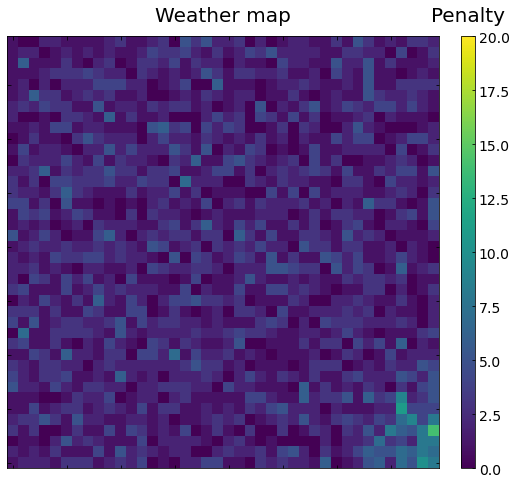

DECODED WEATHER MAP
14.39,  4.82,  8.82,  -2.69,  8.34,  18.99,  -8.14,  1.53,  -36.60,  -21.68,  -14.06,  4.29,  -6.30,  -26.65,  -10.40,  39.35,  3.95,  -3.15,  6.42,  15.57
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

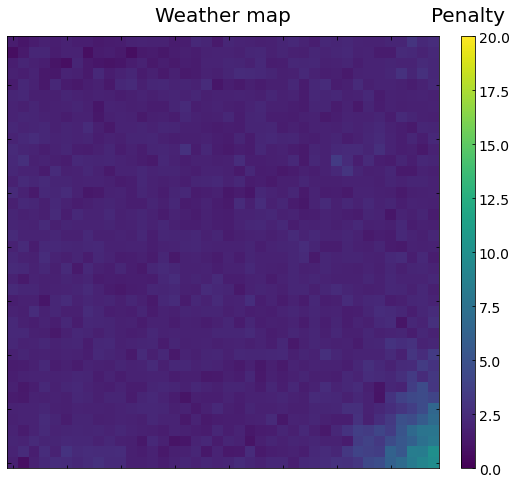

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

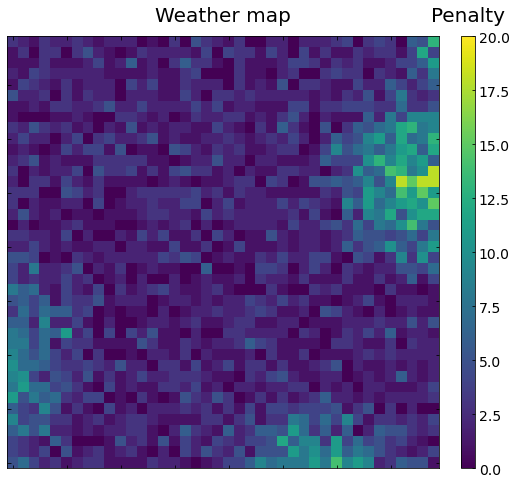

DECODED WEATHER MAP
-0.36,  1.01,  -3.26,  2.33,  -0.86,  2.28,  3.23,  -1.06,  2.34,  -1.94,  2.32,  0.75,  -1.82,  3.13,  1.02,  -1.23,  -1.00,  1.24,  -0.74,  1.63
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

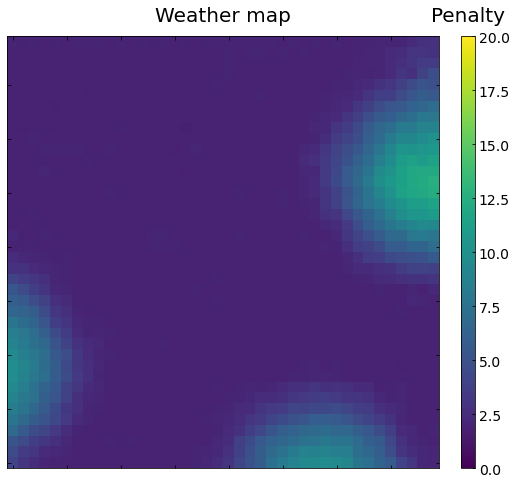

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

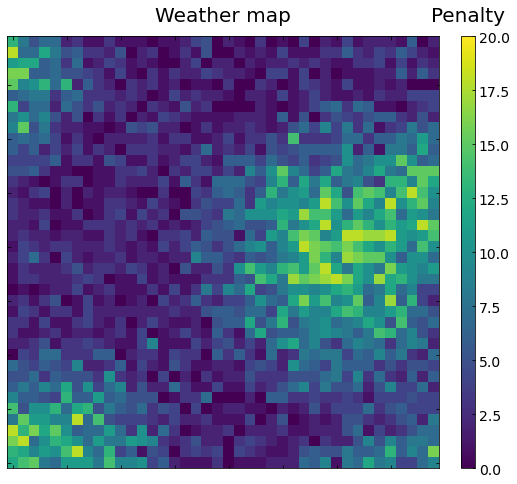

DECODED WEATHER MAP
-2.00,  2.26,  -2.69,  1.84,  2.53,  -2.92,  6.87,  -5.86,  4.62,  2.86,  1.20,  0.81,  -0.77,  4.52,  1.45,  -4.40,  2.56,  3.70,  -1.89,  -1.58
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

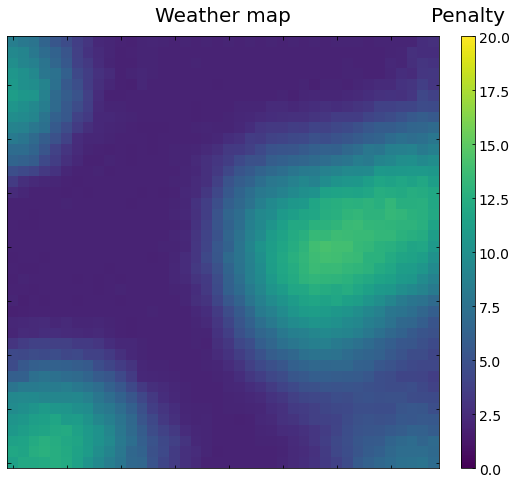

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

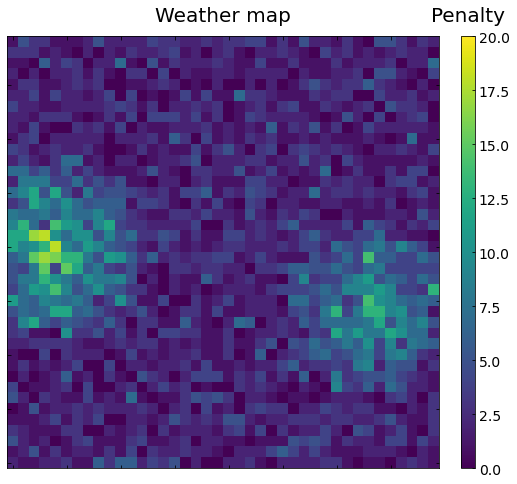

DECODED WEATHER MAP
3.73,  -0.84,  1.77,  3.15,  -0.01,  1.66,  0.31,  -1.38,  1.09,  1.72,  -0.40,  -1.66,  1.91,  4.81,  4.85,  -4.44,  1.23,  -0.20,  -0.56,  1.20
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

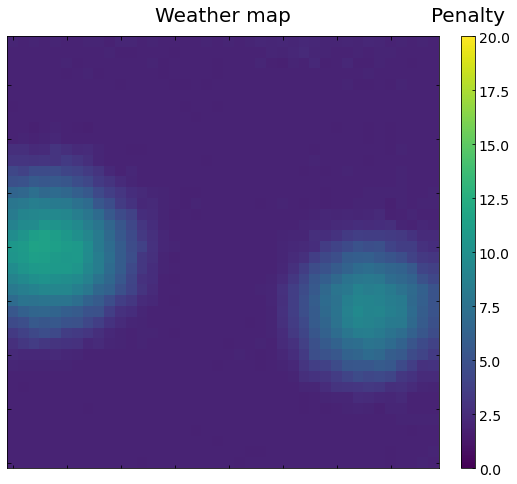

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

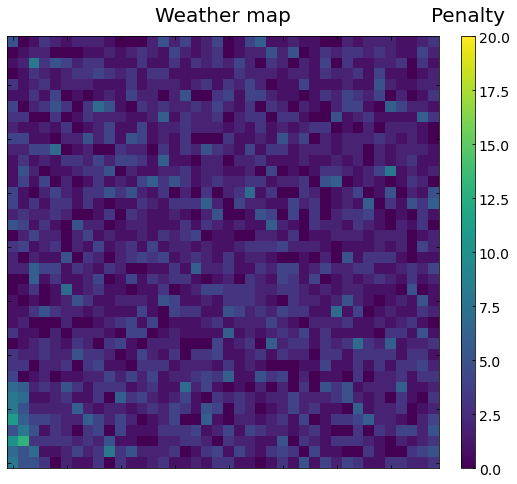

DECODED WEATHER MAP
15.06,  5.48,  9.77,  -1.58,  8.41,  20.17,  -8.26,  2.76,  -38.13,  -24.12,  -17.12,  3.55,  -8.44,  -27.25,  -12.12,  42.95,  4.57,  -2.51,  7.81,  16.60
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

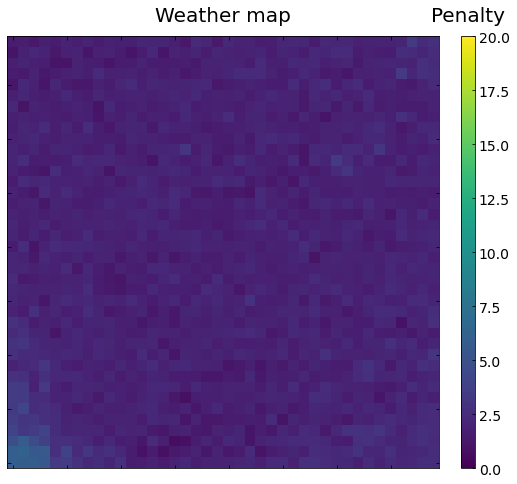

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

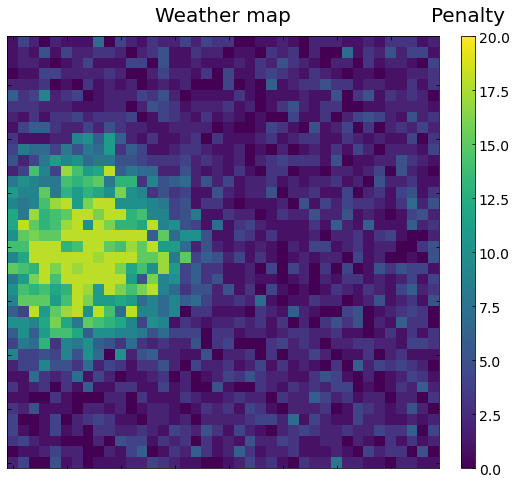

DECODED WEATHER MAP
3.14,  -6.38,  -0.07,  6.29,  -0.21,  -0.48,  -1.97,  2.96,  3.08,  1.98,  -0.17,  -1.49,  1.71,  3.07,  8.38,  -1.69,  -0.88,  -2.44,  -1.99,  -0.25
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

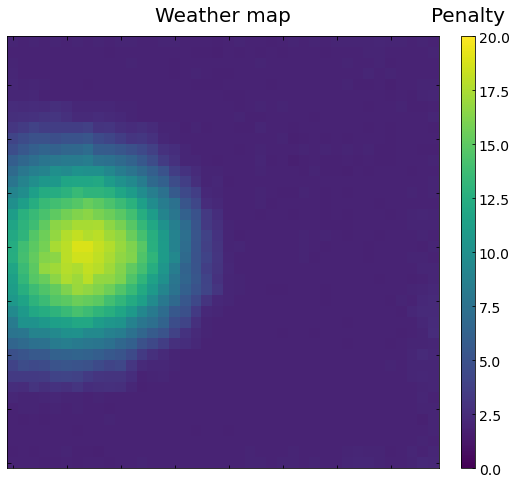

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

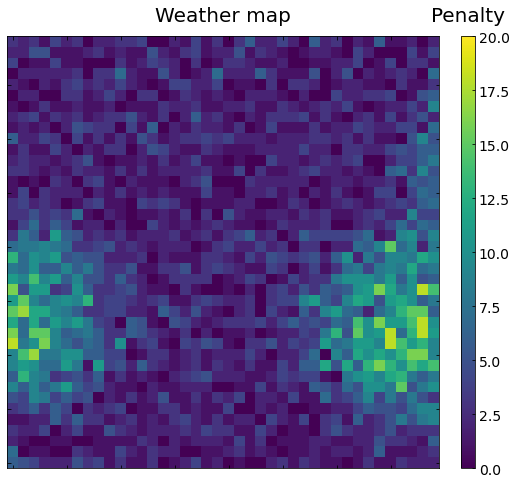

DECODED WEATHER MAP
3.97,  2.30,  2.00,  3.17,  0.66,  0.87,  1.72,  -3.78,  3.26,  0.32,  1.44,  0.68,  1.54,  6.67,  4.49,  -1.72,  0.56,  0.08,  -0.06,  1.45
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

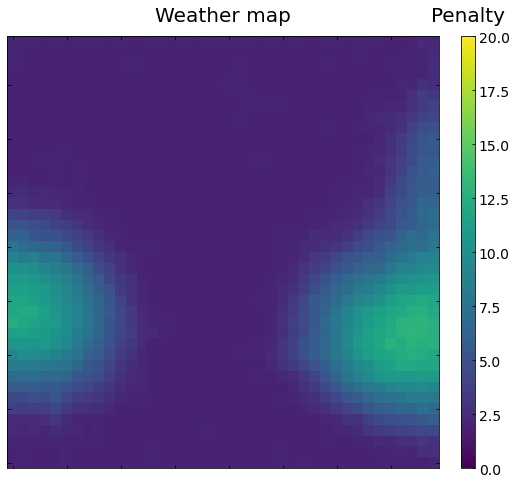

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

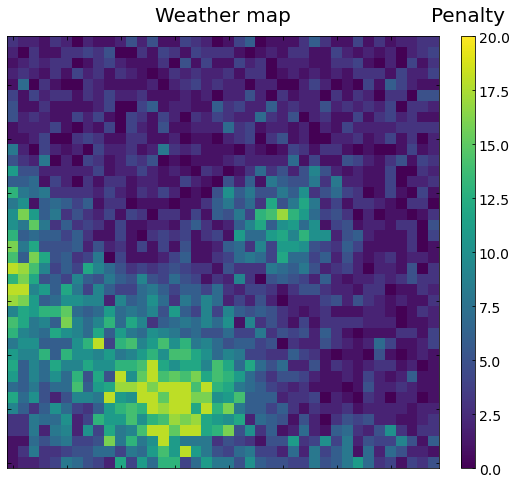

DECODED WEATHER MAP
-0.14,  -0.59,  -5.02,  1.04,  -0.79,  -0.76,  -1.22,  -0.03,  5.18,  -1.79,  0.81,  3.43,  -1.54,  4.99,  6.00,  -9.16,  1.31,  -1.89,  2.05,  -3.69
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

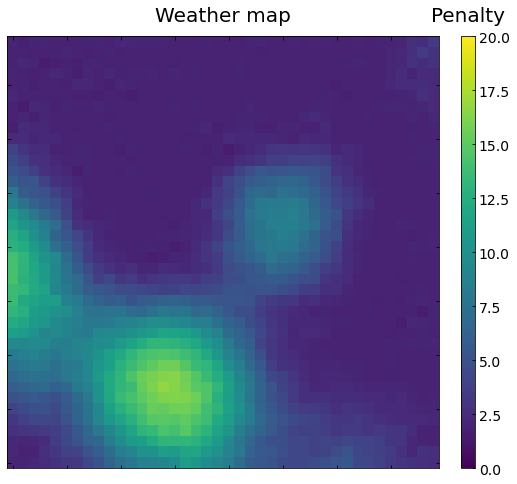

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

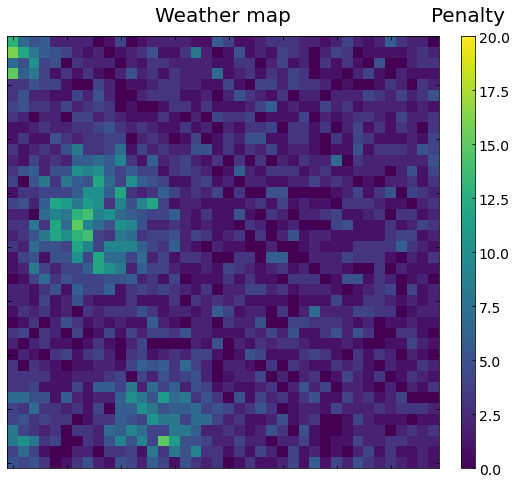

DECODED WEATHER MAP
0.79,  -2.72,  1.41,  1.33,  -2.24,  -1.23,  -1.60,  1.79,  2.32,  2.15,  -2.33,  0.38,  -0.03,  0.32,  4.67,  -2.07,  -0.15,  -0.61,  1.05,  0.08
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

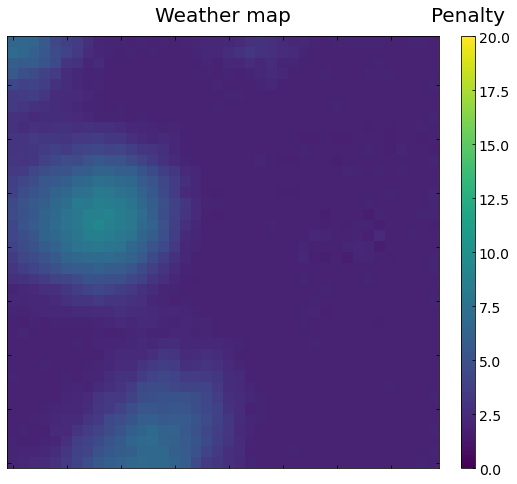

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

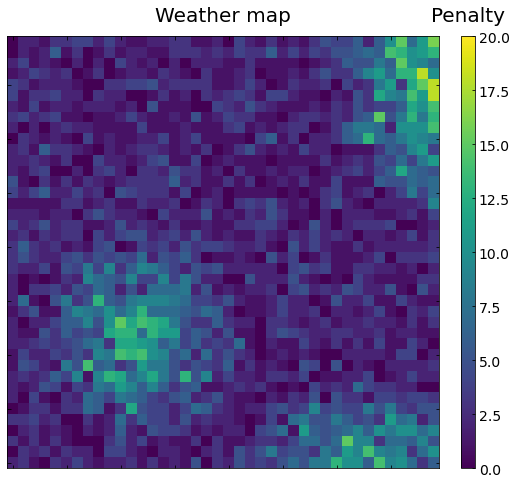

DECODED WEATHER MAP
-3.11,  -0.20,  -1.19,  1.37,  -1.51,  0.79,  0.72,  0.31,  2.73,  0.19,  5.13,  3.37,  -0.12,  3.67,  5.30,  -3.29,  -2.80,  -0.81,  -0.58,  0.29
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

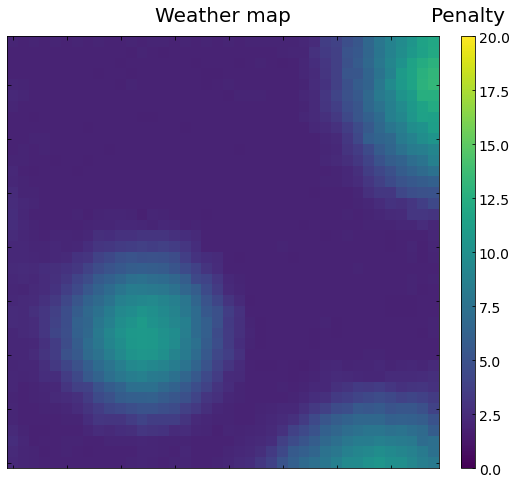

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

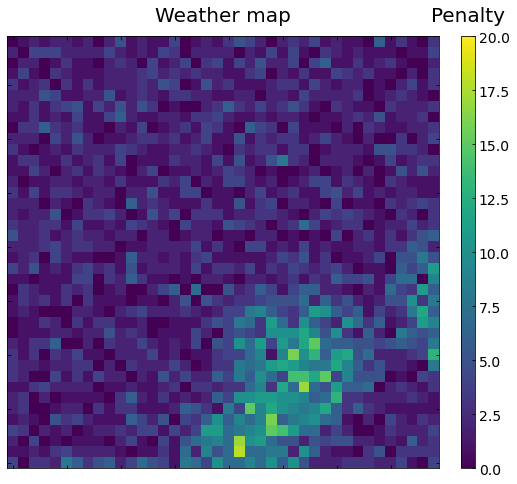

DECODED WEATHER MAP
1.58,  3.20,  1.13,  -0.23,  -0.54,  2.04,  1.01,  -1.91,  1.59,  2.01,  -2.95,  1.42,  0.35,  1.61,  -1.27,  -3.98,  -0.45,  -0.26,  -1.76,  -1.77
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

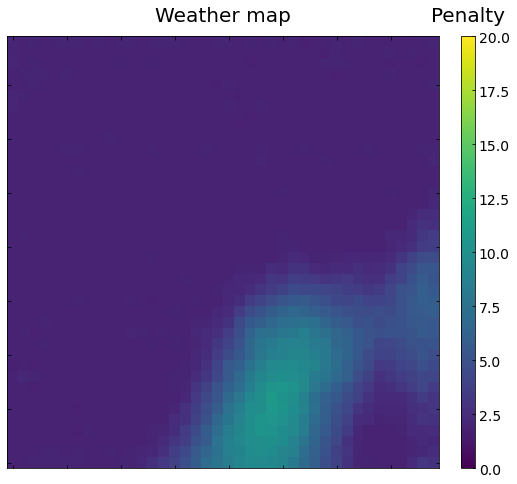

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

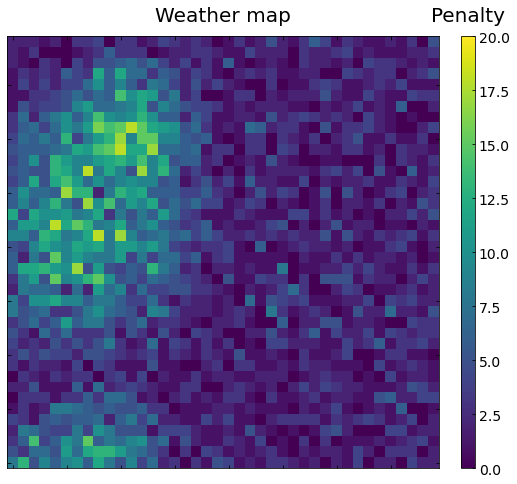

DECODED WEATHER MAP
0.83,  -4.23,  0.55,  3.74,  -2.62,  -3.33,  -0.55,  1.11,  4.98,  2.11,  0.96,  -3.62,  -1.65,  0.21,  5.68,  -1.33,  1.84,  -3.50,  1.36,  -0.25
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

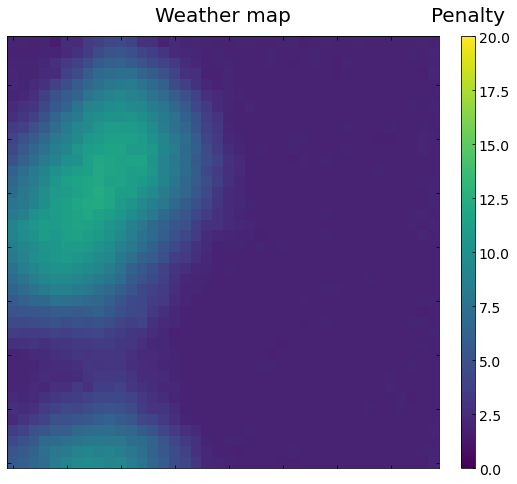

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

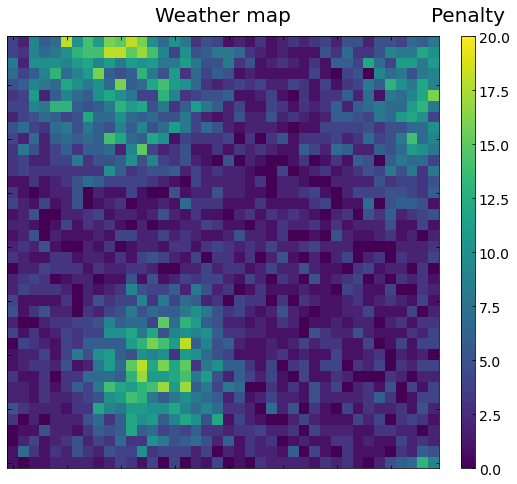

DECODED WEATHER MAP
-3.69,  -2.43,  1.77,  -2.27,  -1.68,  -4.41,  0.54,  0.35,  5.91,  1.08,  3.60,  0.95,  -0.31,  4.60,  2.13,  -1.71,  -0.46,  -1.42,  1.57,  0.71
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

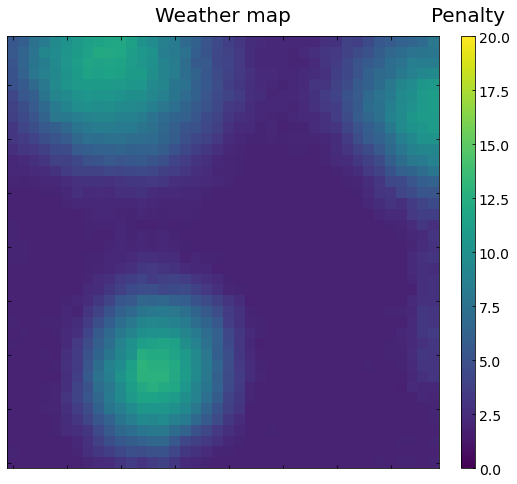

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

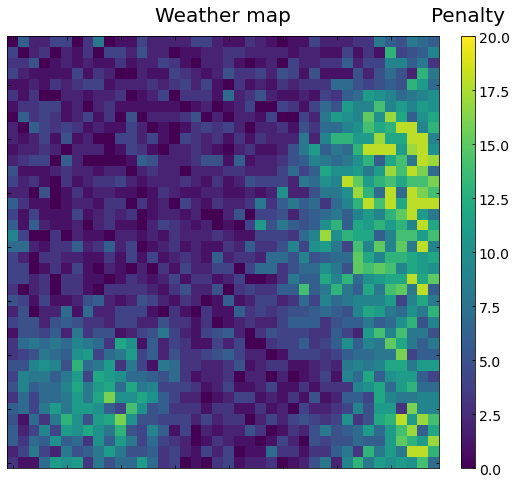

DECODED WEATHER MAP
-1.90,  3.97,  -3.52,  -0.27,  2.06,  -0.90,  5.13,  -5.03,  3.67,  2.15,  5.61,  1.71,  0.27,  5.42,  5.06,  -1.84,  -0.43,  2.24,  0.04,  -1.19
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

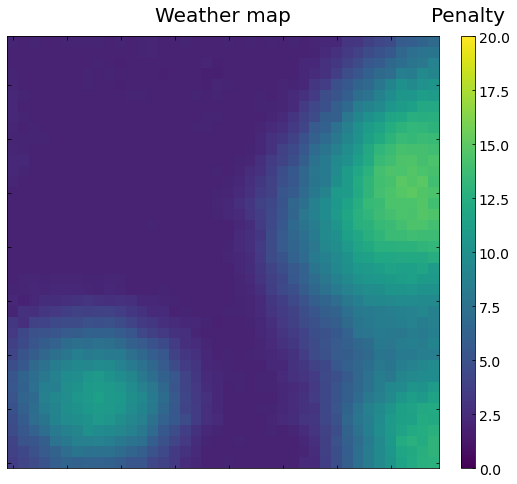

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

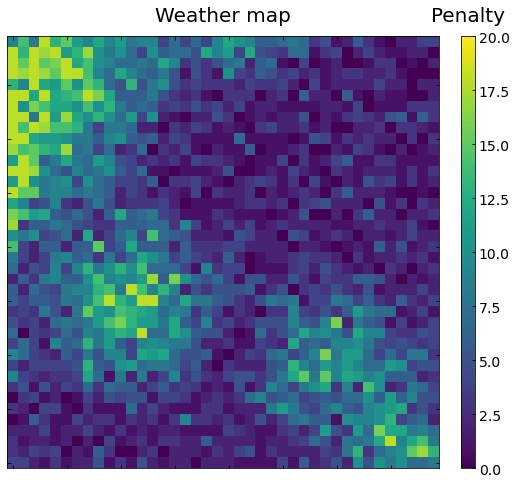

DECODED WEATHER MAP
1.00,  -5.04,  2.58,  4.32,  -4.17,  -6.17,  1.92,  -1.86,  3.02,  3.43,  2.46,  2.26,  3.77,  5.10,  2.81,  -5.21,  -2.96,  -0.52,  -4.48,  -1.11
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

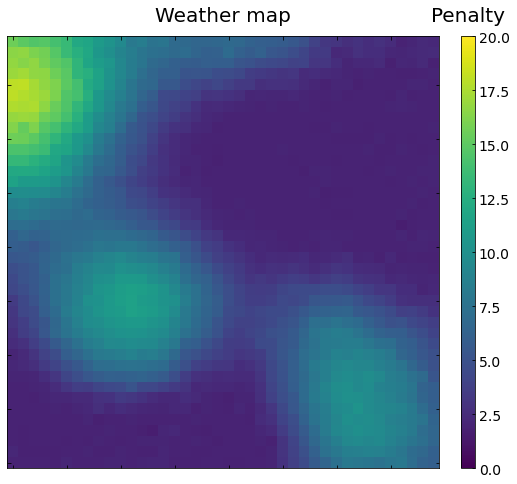

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

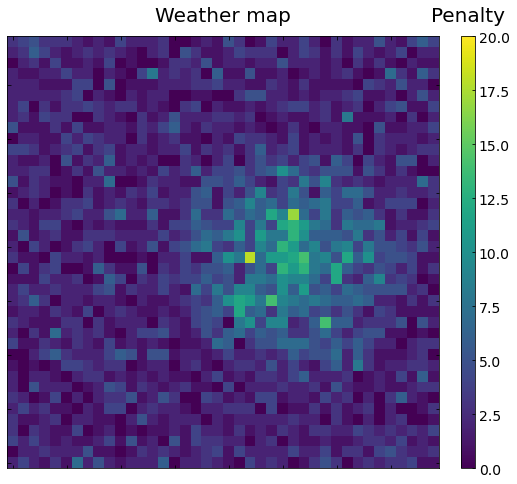

DECODED WEATHER MAP
-0.99,  -0.01,  -0.19,  2.54,  1.53,  1.10,  0.47,  -2.88,  2.38,  2.46,  0.25,  1.17,  0.64,  2.31,  -0.34,  -6.30,  2.13,  1.89,  -1.40,  0.77
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

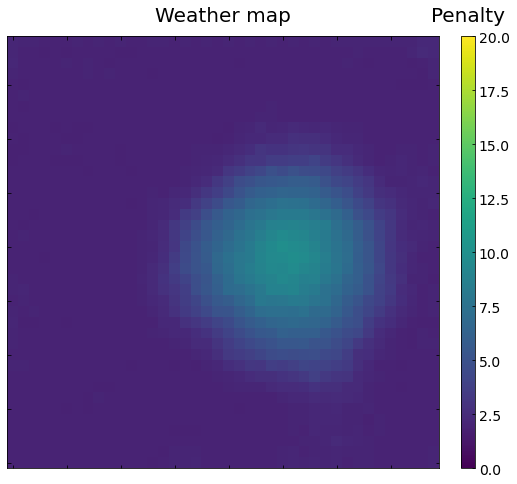

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

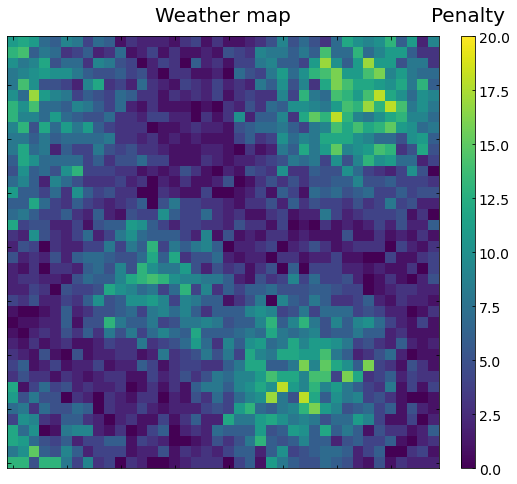

DECODED WEATHER MAP
-2.43,  -2.18,  -0.09,  2.35,  -1.52,  -2.65,  1.06,  1.49,  3.30,  6.57,  1.44,  0.41,  -2.31,  8.18,  2.18,  -3.89,  -3.19,  2.24,  -4.66,  -1.42
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

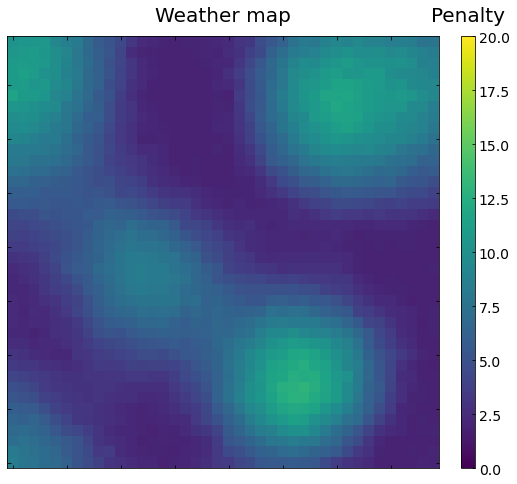

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

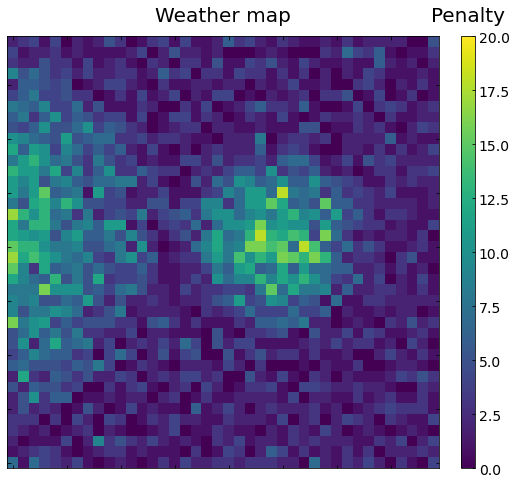

DECODED WEATHER MAP
0.17,  -2.93,  -2.95,  5.17,  1.17,  -3.10,  -2.10,  -2.53,  4.05,  1.02,  0.06,  -1.79,  0.73,  2.73,  3.54,  -6.20,  2.94,  -0.36,  -3.35,  1.45
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

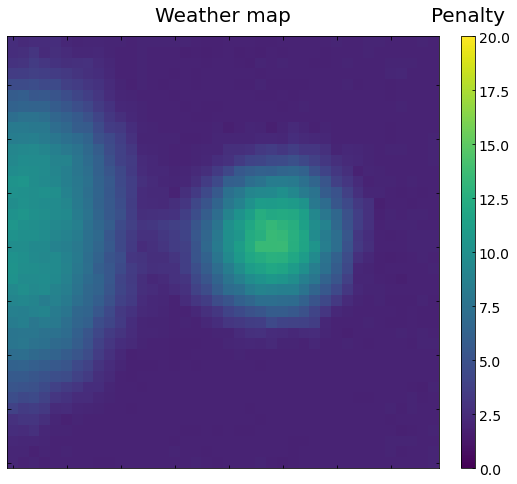

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

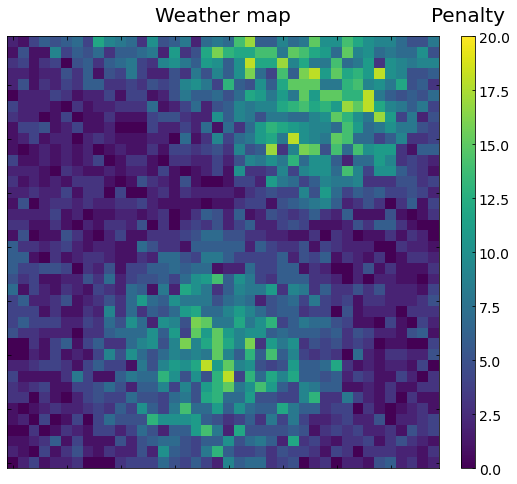

DECODED WEATHER MAP
-3.58,  -0.99,  -2.05,  -0.37,  -1.09,  -1.59,  -0.34,  2.02,  2.80,  4.97,  2.34,  2.69,  -0.42,  8.37,  -0.50,  -5.80,  0.33,  1.97,  -0.15,  0.04
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

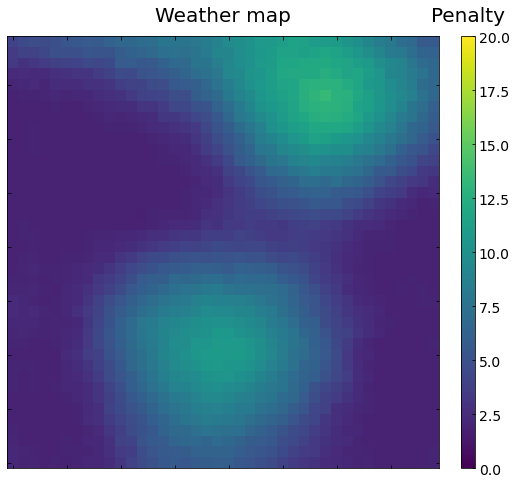

ORIGINAL WEATHER MAP


<Figure size 432x288 with 0 Axes>

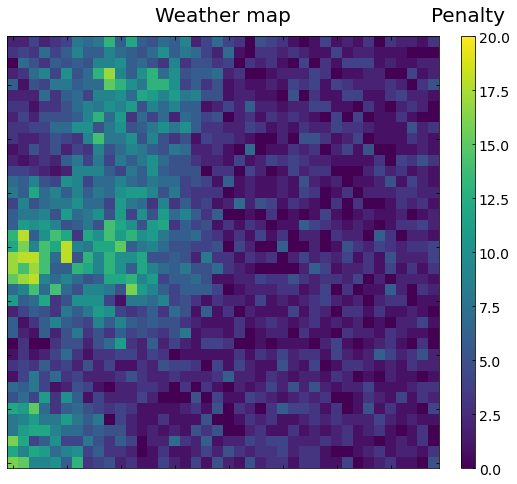

DECODED WEATHER MAP
0.72,  -4.64,  1.56,  6.01,  -2.55,  -3.33,  0.48,  3.35,  5.51,  1.94,  -0.25,  -1.35,  -3.09,  2.10,  4.11,  -2.09,  1.84,  -3.34,  0.43,  0.96
DECODED WEATHER MAP


<Figure size 432x288 with 0 Axes>

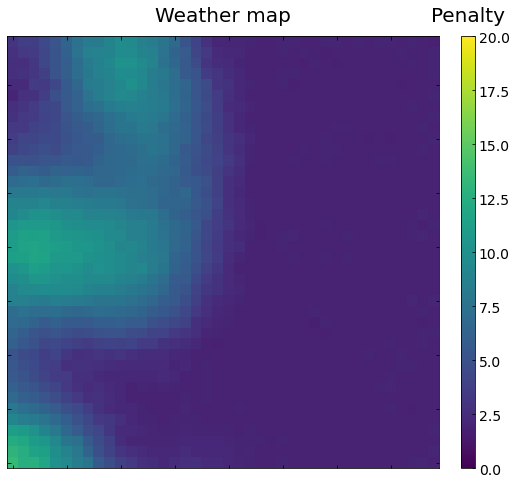

<Figure size 432x288 with 0 Axes>

In [15]:
###
###  Generate some weather maps and plot the original vs autoencoded image to visually check that the
###  embedding contains sufficient information to reconstruct the main weather systems
###  -  N.B. by passing through a bottleneck we actually create a 'denoising autoencoder'. This is because the 
###     bottleneck does not preserve information on individual pixel fluctuations, partly because we discard 
###     this information when performing convolutions with a small number of kernels, partly because we
###     discard info when maxpooling, and partly because we don't have the capacity to reconstruct individual
###     pixels without having many more deconv kernels (therefore this is no motivation (== gradient) towards 
###     retaining this information). This, along with the limited complexity of the image reconstruction, 
###     leads to the output being much smoother than the input. Since the optimal MSE is achieved by averaging
###     out the noise fluctuations, we have therefore 'denoised' the image.
###

num_generated_maps = 20

for i in range(num_generated_maps) :
    weather_map = generate_map()
    print("==="*20)
    print("ORIGINAL WEATHER MAP")
    create_weather_plot(weather_map, show=True, close=True)
    print("DECODED WEATHER MAP")
    encoded_map = encoder_model(weather_map.reshape(1,square_size,square_size,1))[0].numpy()
    print(",  ".join([f'{x:.2f}' for x in encoded_map]))
    print("DECODED WEATHER MAP")
    autoencoded_map = autoencoder_model(weather_map.reshape(1,square_size,square_size,1))[0].numpy()
    create_weather_plot(autoencoded_map, show=True, close=True)
    print("==="*20)
    

In [16]:
###
###  Save our models
###

top_dir         = "models/2D_static_weather_20220808_emb20"
autoencoder_dir = top_dir + "/autoencoder"
encoder_dir     = top_dir + "/encoder"

generate_directory_for_file_path(autoencoder_dir)
autoencoder_model.save(autoencoder_dir)
encoder_model.save(encoder_dir)


Directory models/2D_static_weather_20220808_emb20 created
INFO:tensorflow:Assets written to: models/2D_static_weather_20220808_emb20/autoencoder/assets
INFO:tensorflow:Assets written to: models/2D_static_weather_20220808_emb20/encoder/assets


In [17]:
###
###  Save the configuration objects
###

config_dir = top_dir + "/training_details.pickle"
settings = {}
settings["square_size"          ] = square_size
settings["max_weather_intensity"] = max_weather_intensity
settings["embedding_length"     ] = embedding_length
#settings["data_X_np"            ] = data_X_np
pickle.dump(settings, open(config_dir, "wb"))


'\n\ndef create_q_models(encoder_model, name="Baseline") :\n    embedding_size = encoder_model.layers[-1].output_shape[-1]\n    input_layer    = Input((embedding_size,))\n    next_layer     = Dense(100        , activation="relu"  , name="q_model_dense_1")(input_layer)\n    next_layer     = Dense(400        , activation="relu"  , name="q_model_dense_2")(next_layer)\n    next_layer     = Dense(400        , activation="relu"  , name="q_model_dense_3")(next_layer)\n    next_layer     = Dense(100        , activation="relu"  , name="q_model_dense_4")(next_layer)\n    output_layer   = Dense(num_actions, activation="linear", name="q_model_output")(next_layer)\n    vec_to_q_model = Model(input_layer, output_layer, name=f"{name}_vec_to_q")\n    vec_to_q_model.compile(loss="mse", optimizer="sgd")\n    full_input = Input((square_size, square_size, 1))\n    next_layer = full_input\n    for layer in encoder_model.layers[1:] :\n        next_layer = layer(next_layer, training=False)\n    for layer in 